# <center> Week 9
___
Do the bonus part of the midterm, trying to get the best predictions possible.  Your grade will come from two parts:

  1) Using good techniques to build your final model.  Be sure to have some comments here and there so we understand your thinking.  It doesn't have to be massive paragraphs explaining things in excruciating detail, just enough so that we can follow what you're doing and why.

  2) How good your predictions are.  We'll use mean squared-error with the price prediction and accuracy for the above/below median price classification.

 

Also, this will be the first assignment I will call some people up to present their solutions to the class.  Be sure to attend in person if you can.

#### 1. Pre-processing the data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.compose import make_column_selector
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer


import warnings

warnings.filterwarnings('ignore')

test = pd.read_csv('house_SalePrice_predict.csv')

df = pd.read_csv('house_SalePrice.csv')

2). use one-hot enconding to convert the categorical variables into dummies.

#### 2. Regresssion model building
In this part, you need to use the data to build a linear model by using OLS first and then build another linear model by using Lasso. Make sure to split the data into training and test sets. Report the performance on test set. Using k-fold cross validation to tune the hyperparameters in Lasso.

In [ ]:
X_train , X_test,y_train, y_test = train_test_split(df.drop(['SalePrice'], 
                                                            axis = 1), df['SalePrice'],
                                                     test_size=0.33, random_state=42)

num_selector = make_column_selector(dtype_include=np.number)
cat_selector = make_column_selector(dtype_include=object)

col_trans = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore', 
                                                   drop = 'first'), cat_selector),
                                    (StandardScaler(), num_selector),
                                  remainder = 'passthrough')

## Use the median to impute missing values 
transformer = FeatureUnion(
    transformer_list=[
                      ('features', SimpleImputer(strategy='most_frequent'))])

ols_pipe = Pipeline(steps = [
                         ('preprocess', col_trans),
                         ('transformer', transformer), 
                         ('model', LinearRegression())
                         ])

lasso_pipe = Pipeline(steps = [
                         ('preprocess', col_trans), 
                         ('transformer', transformer), 
                         ('model', linear_model.Lasso(max_iter=10000))])

ridge_pipe = Pipeline(steps = [
                         ('preprocess', col_trans), 
                         ('transformer', transformer), 
                         ('model', linear_model.Ridge(max_iter=10000))])
rf_pipe = Pipeline(steps = [
                         ('preprocess', col_trans), 
                         ('transformer', transformer), 
                         ('model', RandomForestRegressor())])

## Individual Models

### OLS

In [ ]:
ols_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

ols_preds = ols_pipe.predict(X_test)
print(f'mean square error: {"{:,}".format(mse(ols_preds, y_test))}')

mean square error: 1,746,990,255.574725


Text(0, 0.5, 'Real')

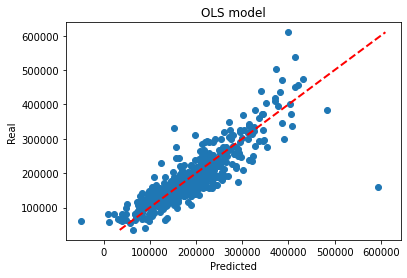

In [ ]:
plt.scatter(ols_preds, y_test)
plt.plot(
        [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2
    )
plt.title("OLS model")
plt.xlabel("Predicted")
plt.ylabel("Real")

# LASSO

In [ ]:
param_lasso = {'model__alpha': [540, 550, 551, 555, 556]}

lasso_grid = GridSearchCV(lasso_pipe, cv = 5, param_grid=param_lasso, scoring="neg_mean_squared_error")

lasso_grid.fit(X_train, y_train)
lasso_preds = lasso_grid.predict(X_test)

print(f'mean square error: {"{:,}".format(mse(lasso_preds, y_test))}')
lasso_grid.best_params_

mean square error: 1,583,223,004.6295633


{'model__alpha': 550}

Text(0, 0.5, 'Real')

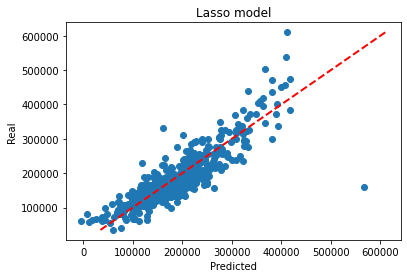

In [ ]:
plt.scatter(lasso_preds, y_test)
plt.plot(
        [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2
    )
plt.title("Lasso model")
plt.xlabel("Predicted")
plt.ylabel("Real")

# RIDGE 

In [ ]:
param_ridge = {'model__alpha': [60, 70, 80, 90 ]}

ridge_grid = GridSearchCV(ridge_pipe, cv = 5, param_grid=param_ridge, scoring="neg_mean_squared_error")

ridge_grid.fit(X_train, y_train)
ridge_preds = lasso_grid.predict(X_test)

print(f'mean square error: {"{:,}".format(mse(y_test, ridge_preds))}')
ridge_grid.best_params_

mean square error: 1,583,223,004.6295633


{'model__alpha': 70}

Text(0, 0.5, 'Real')

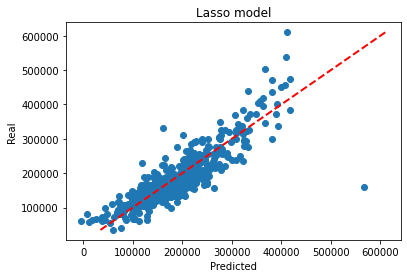

In [ ]:
plt.scatter(ridge_preds, y_test)
plt.plot(
        [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2
    )
plt.title("Lasso model")
plt.xlabel("Predicted")
plt.ylabel("Real")

# Stacking 




#### 3. Classification model building


In [ ]:
estimators = [
     ('lasso_model', lasso_pipe),
     ('ridge_model', ridge_pipe),
     ('ols_model', ols_pipe),
     ('rf_model', rf_pipe)]

clf = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

parameters = {'lasso_model__model__alpha': [500, 550],
              'ridge_model__model__alpha': [60, 70, 80],
              'rf_model__model__max_depth' : [i for i in range(4)], 
              'rf_model__model__max_features': ['sqrt']}

clf_gs = GridSearchCV(clf, parameters, cv = 5, scoring = "neg_mean_squared_error")

clf_gs.fit(X_train, y_train)

y_preds = clf_gs.predict(X_test)


In [ ]:
print(f'mean square error: {"{:,}".format(mse(y_test, y_preds))}')

mean square error: 1,452,889,923.3148556


Text(0, 0.5, 'Real')

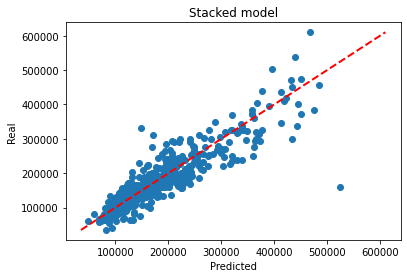

In [ ]:
plt.scatter(y_preds, y_test)
plt.plot(
        [y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--r", linewidth=2
    )
plt.title("Stacked model")
plt.xlabel("Predicted")
plt.ylabel("Real")

I use the mode as the imputation technique, and use one hote encoding and scale the data as preprocessing. 
I use an OLS, ridge, lasso and Random Forest Regression independently. The best of these models were the ridge, and lasso.

After that I stacked the models. This stacked model got an smaller mean squared error than all the other models.

# Categorical Classification

In [ ]:
df2 = df.copy()
df2['above_median'] = df2['SalePrice'].apply(lambda x: 1 if x > np.median(df['SalePrice']) else 0)
df2.drop(['SalePrice'], axis = 1, inplace=True)

X_train2 , X_test2, y_train2, y_test2 = train_test_split(df2.drop(['above_median'], 
                                                            axis = 1), df2['above_median'],
                                                     test_size=0.33, random_state=42)

col_trans = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore', 
                                                   drop = 'first'), cat_selector),
                                    (StandardScaler(), num_selector),
                                     remainder = 'passthrough')

transformer = FeatureUnion(
    transformer_list=[
                      ('features', SimpleImputer(strategy='most_frequent'))])


logistic_pipe = Pipeline(steps = [
                         ('preprocess', col_trans), 
                         ('transformer', transformer), 
                         ('model', linear_model.LogisticRegression())])

logistic_lasso_pipe = Pipeline(steps = [
                         ('preprocess', col_trans), 
                         ('transformer', transformer), 
                         ('model', linear_model.LogisticRegression(penalty = 'l1',
                                                                   solver = 'liblinear'))])
logistic_ridge_pipe = Pipeline(steps = [
                         ('preprocess', col_trans), 
                         ('transformer', transformer), 
                         ('model', linear_model.LogisticRegression(penalty = 'l2'))])

rf_pipe = Pipeline(steps = [
                         ('preprocess', col_trans), 
                         ('transformer', transformer), 
                         ('model', RandomForestClassifier())])


# Ridge

In [ ]:
params = {'model__C': [0.1, 1, 1.5,2, 10]}

lrp = GridSearchCV(logistic_ridge_pipe, cv = 5, param_grid= params)  

lrp.fit(X_train2, y_train2)

y_preds_ridge = lrp.predict(X_test2)

lrp.best_params_

{'model__C': 2}

In [ ]:
accuracy_score(y_test2, y_preds_ridge)

0.888468809073724

## Lasso

In [ ]:
params = {'model__C': [0.1, 1, 1.5,2, 10]}

lasso_lg = GridSearchCV(logistic_lasso_pipe, cv = 5, param_grid= params)  

lasso_lg.fit(X_train2, y_train2)

y_preds_ridge = lasso_lg.predict(X_test2)

lasso_lg.best_params_

{'model__C': 1}

In [ ]:
accuracy_score(y_test2, y_preds_ridge)

0.8846880907372401

## Random Forest

In [ ]:
params = {'model__max_depth' : [i for i in range(4)], 
          'model__max_features': ['sqrt']}

rf_gs = GridSearchCV(rf_pipe, cv = 5, param_grid= params)  

rf_gs.fit(X_train2, y_train2)

y_preds_rf = rf_gs.predict(X_test2)

rf_gs.best_params_

{'model__max_depth': 2, 'model__max_features': 'sqrt'}

In [ ]:
accuracy_score(y_test2, y_preds_rf)

0.8827977315689981

## Stacked Model

In [ ]:
estimators = [
     ('rf',rf_pipe),
     ('lasso', logistic_lasso_pipe),
     ('ridge', logistic_ridge_pipe),
     ('logistic', logistic_pipe)]
 

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

parameters_cat = {
              'lasso__model__C': [0.005, 0.01, 0.1],
              'ridge__model__C': [0.1, 1, 1.5],
              'rf__model__max_depth' : [i for i in range(7)], 
              'rf__model__max_features': ['sqrt']}

clf_cat = GridSearchCV(clf, parameters_cat, cv = 5, verbose = 10, scoring = "accuracy")

clf_cat.fit(X_train2, y_train2)

cat_preds = clf_cat.predict(X_test2)

accuracy_score(y_test2, cat_preds)

[CV 1/5; 63/63] END lasso__model__C=0.1, rf__model__max_depth=6, rf__model__max_features=sqrt, ridge__model__C=1.5;, score=0.893 total time=   2.9s
[CV 2/5; 63/63] START lasso__model__C=0.1, rf__model__max_depth=6, rf__model__max_features=sqrt, ridge__model__C=1.5
[CV 2/5; 63/63] END lasso__model__C=0.1, rf__model__max_depth=6, rf__model__max_features=sqrt, ridge__model__C=1.5;, score=0.916 total time=   2.9s
[CV 3/5; 63/63] START lasso__model__C=0.1, rf__model__max_depth=6, rf__model__max_features=sqrt, ridge__model__C=1.5
[CV 3/5; 63/63] END lasso__model__C=0.1, rf__model__max_depth=6, rf__model__max_features=sqrt, ridge__model__C=1.5;, score=0.907 total time=   2.9s
[CV 4/5; 63/63] START lasso__model__C=0.1, rf__model__max_depth=6, rf__model__max_features=sqrt, ridge__model__C=1.5
[CV 4/5; 63/63] END lasso__model__C=0.1, rf__model__max_depth=6, rf__model__max_features=sqrt, ridge__model__C=1.5;, score=0.921 total time=   2.9s
[CV 5/5; 63/63] START lasso__model__C=0.1, rf__model__max

0.8903591682419659

All the models were very good, with an accuracy score of 88 percent. However, using stacking increased the accuracy score to 89.

#### 5. Test your model (Bonus)

In [ ]:
my_predictions = pd.DataFrame({"salePrice":y_preds, "aboveMedian": cat_preds})

my_predictions.to_csv("Charris_prediction.csv")